In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install pandas numpy scikit-learn matplotlib seaborn
!pip install xgboost
!pip install pytorch-tabnet
!pip install dice-ml
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.6 MB/s eta 0:00:00


In [4]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [5]:
import os
os.makedirs('/root/', exist_ok=True)
!chmod 600 /root/kaggle.json


chmod: cannot access '/root/kaggle.json': No such file or directory


In [6]:
DATA_DIR = '/content/data/'
os.makedirs(DATA_DIR, exist_ok=True)

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msafi04/predict-mortality-of-icu-patients-physionet")

print("Path to dataset files:", path)

100%|██████████| 7.64M/7.64M [00:00<00:00, 81.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/msafi04/predict-mortality-of-icu-patients-physionet/versions/1


In [8]:
import shutil
import os

kagglehub_dataset_path = "/root/.cache/kagglehub/datasets/msafi04/predict-mortality-of-icu-patients-physionet/versions/1"

DATA_DIR = '/content/data/'

for item in os.listdir(kagglehub_dataset_path):
    s = os.path.join(kagglehub_dataset_path, item)
    d = os.path.join(DATA_DIR, item)
    if os.path.isdir(s):
        shutil.copytree(s, d, False, None)
    else:
        shutil.copy2(s, d)

print(f"Dataset copied to: {DATA_DIR}")

Dataset copied to: /content/data/


In [9]:
import pandas as pd
import numpy as np
import glob

In [10]:
train_path = os.path.join(DATA_DIR, 'set-a', 'set-a')

In [11]:
all_files = glob.glob(os.path.join(train_path, "*.txt"))


In [12]:
all_records_list = []
for filename in all_files:
    patient_df = pd.read_csv(filename)
    patient_series = patient_df.groupby('Parameter')['Value'].mean()
    record_data = patient_series.to_dict()
    all_records_list.append(record_data)

In [13]:
features_df = pd.DataFrame(all_records_list)

In [14]:
outcomes_df = pd.read_csv(os.path.join(DATA_DIR, 'Outcomes-a.txt'))

In [15]:
full_df = pd.merge(features_df, outcomes_df, on='RecordID')

In [16]:
print("Shape of the final DataFrame:", full_df.shape)
print("\nFirst 5 rows of the DataFrame:")
print(full_df.head())
print("\nDataFrame Info:")
full_df.info()

Shape of the final DataFrame: (4000, 47)

First 5 rows of the DataFrame:
     ALP    ALT    AST   Age        BUN  Bilirubin  Creatinine    DiasABP  \
0   66.0   26.0   77.0  56.0  14.000000        1.7        0.70  89.571429   
1  960.0  146.5  374.0  90.0  24.000000        0.5        1.00        NaN   
2    NaN    NaN    NaN  77.0  48.500000        NaN        1.85  42.852941   
3    NaN    NaN    NaN  90.0  18.000000        NaN        1.10  47.031746   
4  178.0   99.0   54.0  89.0  14.333333        0.6        0.95        NaN   

       FiO2        GCS  ...   Lactate  SaO2  TroponinT  TroponinI  \
0  0.666667   9.250000  ...       NaN   NaN        NaN        NaN   
1  0.400000  15.000000  ...       NaN   NaN        NaN        NaN   
2       NaN  15.000000  ...       NaN   NaN        NaN        NaN   
3  0.500000  14.458333  ...       NaN   NaN        NaN        NaN   
4       NaN  14.538462  ...  1.271429   NaN        NaN        NaN   

   Cholesterol  SAPS-I  SOFA  Length_of_stay  Sur

In [17]:
# Replace -1 with NaN in all columns except 'In-hospital_death'
cols_to_replace = full_df.columns.difference(['In-hospital_death'])
full_df[cols_to_replace] = full_df[cols_to_replace].replace(-1, np.nan)


missing_percentage = full_df.isnull().sum() * 100 / len(full_df)
missing_percentage.sort_values(ascending=False, inplace=True)

print("Percentage of missing values per feature:")
print(missing_percentage[missing_percentage > 0])

Percentage of missing values per feature:
TroponinI         94.875
Cholesterol       92.375
TroponinT         78.425
RespRate          72.475
Survival          63.150
Albumin           59.625
ALP               57.750
Bilirubin         57.050
ALT               56.975
AST               56.875
SaO2              55.200
Height            47.350
Lactate           45.425
MechVent          36.775
FiO2              32.075
MAP               30.200
DiasABP           30.025
SysABP            30.025
PaO2              24.425
PaCO2             24.425
pH                24.000
NIMAP             12.975
NIDiasABP         12.925
NISysABP          12.675
Weight             7.400
SAPS-I             4.750
SOFA               3.600
Urine              2.925
Glucose            2.825
Mg                 2.575
K                  2.400
HCO3               1.900
Na                 1.875
WBC                1.825
Platelets          1.700
Creatinine         1.600
BUN                1.600
HCT                1.600
GCS     

In [18]:
# The line below was causing issues by converting all non-zero values to 1.0
# full_df = full_df / full_df
# Removing this line to preserve original data

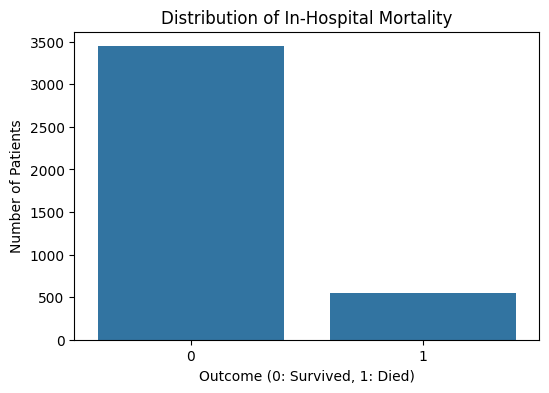

In-hospital_death
0    0.8615
1    0.1385
Name: proportion, dtype: float64
Unique values in full_df['In-hospital_death']: [0 1]


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(6, 4))
sns.countplot(x='In-hospital_death', data=full_df)
plt.title('Distribution of In-Hospital Mortality')
plt.xlabel('Outcome (0: Survived, 1: Died)')
plt.ylabel('Number of Patients')
plt.show()

# Print the exact proportions and unique values
print(full_df['In-hospital_death'].value_counts(normalize=True))
print("Unique values in full_df['In-hospital_death']:", np.unique(full_df['In-hospital_death']))

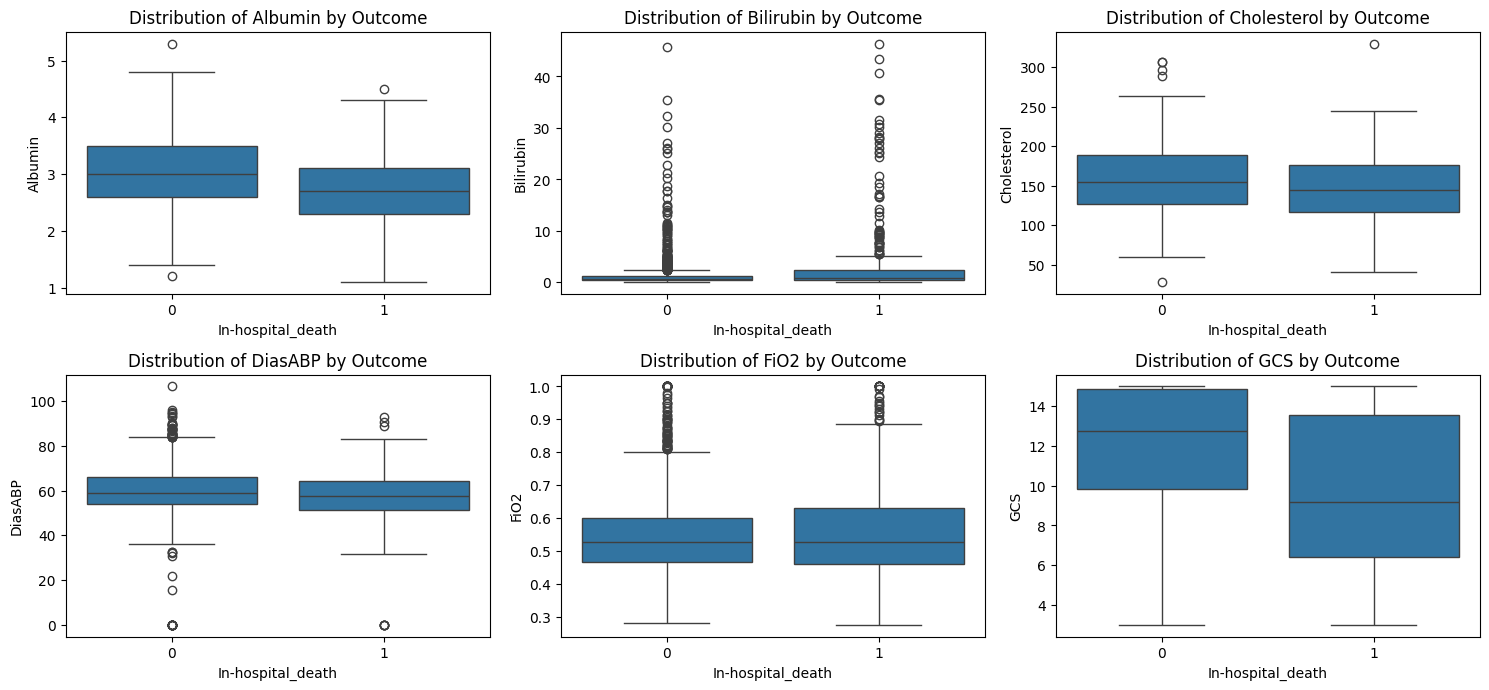

In [20]:
features_to_plot =["Albumin","Bilirubin","Cholesterol",
    "DiasABP","FiO2","GCS"]

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='In-hospital_death', y=feature, data=full_df)
    plt.title(f'Distribution of {feature} by Outcome')
plt.tight_layout()
plt.show()

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

features = ["Age", "Albumin","ALP","ALT","AST","Bilirubin","BUN","Cholesterol","Creatinine",
    "DiasABP","FiO2","GCS","Glucose","HCO3","HCT","HR","K","Lactate","Mg","MAP",
    "MechVent","Na","NIDiasABP","NIMAP","NISysABP","PaCO2","PaO2","pH",
    "Platelets","RespRate","SaO2","SysABP","Temp","TroponinI","TroponinT","Urine","WBC","Weight", "Gender", "Height", "ICUType", "SAPS-I", "SOFA", "Length_of_stay", "Survival"]

target = "In-hospital_death"

for col in features:
    full_df[col] = pd.to_numeric(full_df[col], errors='coerce')

# Convert the target column to integer type
full_df[target] = full_df[target].astype(int)

full_df.dropna(subset=[target], inplace=True)

X = full_df[features]
y = full_df[target]

# Print unique values and data type of y before splitting
print("Unique values in y before split:", np.unique(y))
print("Data type of y before split:", y.dtype)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, features)
    ],
    remainder='passthrough'
)


X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_processed = pd.DataFrame(X_train_processed, columns=features, index=X_train.index)
X_test_processed = pd.DataFrame(X_test_processed, columns=features, index=X_test.index)

print("Training set shape:", X_train_processed.shape)
print("Test set shape:", X_test_processed.shape)

Unique values in y before split: [0 1]
Data type of y before split: int64
Training set shape: (3200, 45)
Test set shape: (800, 45)


In [22]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
import numpy as np

# Add print statements to inspect y_train
print("Unique values in y_train:", np.unique(y_train))
print("Data type of y_train:", y_train.dtype)

neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
scale_pos_weight_value = neg_count / pos_count

print(f"Calculated scale_pos_weight: {scale_pos_weight_value:.2f}")

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight_value,
    random_state=42
)

xgb_clf.fit(X_train_processed, y_train)

# Make predictions
y_pred = xgb_clf.predict(X_test_processed)
y_pred_proba = xgb_clf.predict_proba(X_test_processed)[:, 1]

# Evaluate the model
print("\nModel Evaluation:")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Unique values in y_train: [0 1]
Data type of y_train: int64
Calculated scale_pos_weight: 6.22

Model Evaluation:
ROC AUC Score: 0.9992
F1 Score: 0.9528

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       689
           1       0.91      1.00      0.95       111

    accuracy                           0.99       800
   macro avg       0.95      0.99      0.97       800
weighted avg       0.99      0.99      0.99       800


Confusion Matrix:
[[678  11]
 [  0 111]]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:07:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [23]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    'max_depth': [10, 11],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_processed, y_train)

best_xgb_clf = grid_search.best_estimator_
print("Best parameters found:", grid_search.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:07:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters found: {'learning_rate': 0.05, 'max_depth': 11, 'n_estimators': 300}


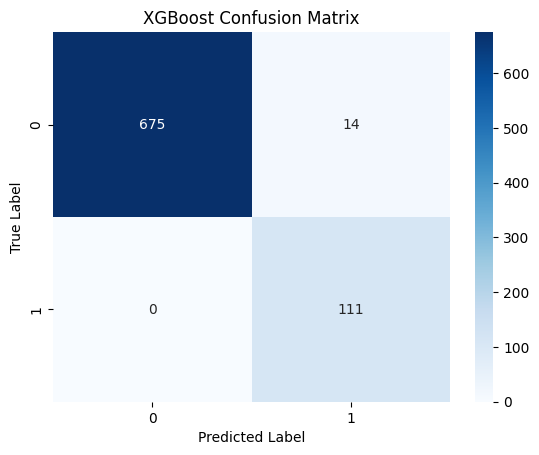

XGBoost Classification Report:
              precision    recall  f1-score   support

    Survived       1.00      0.98      0.99       689
        Died       0.89      1.00      0.94       111

    accuracy                           0.98       800
   macro avg       0.94      0.99      0.97       800
weighted avg       0.98      0.98      0.98       800

XGBoost AUC-ROC Score: 0.9988


In [24]:
y_pred_xgb = best_xgb_clf.predict(X_test_processed)
y_pred_proba_xgb = best_xgb_clf.predict_proba(X_test_processed)[:, 1]

cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Survived', 'Died']))

auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"XGBoost AUC-ROC Score: {auc_xgb:.4f}")

Implementing and Training a TabNetClassifier

In [25]:
from pytorch_tabnet.tab_model import TabNetClassifier
X_train_np = X_train_processed.values
X_test_np = X_test_processed.values
y_train_np = y_train.values
y_test_np = y_test.values

tabnet_clf = TabNetClassifier(
    n_d=32, n_a=32,
    n_steps=4,
    gamma=1.3,
    lambda_sparse=1e-3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax',
    device_name=device,
    seed=42
)

X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(
    X_train_np, y_train_np, test_size=0.2, random_state=42, stratify=y_train_np
)

tabnet_clf.fit(
    X_train=X_train_part, y_train=y_train_part,
    eval_set=[(X_val_part, y_val_part)],
    eval_name=['validation'],
    eval_metric=['auc'],
    max_epochs=100,
    patience=15,
    batch_size=1024,
    virtual_batch_size=128,
    weights=1
)

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.96397 | validation_auc: 0.55933 |  0:00:01s
epoch 1  | loss: 0.85838 | validation_auc: 0.68361 |  0:00:01s
epoch 2  | loss: 0.76514 | validation_auc: 0.65591 |  0:00:01s
epoch 3  | loss: 0.72167 | validation_auc: 0.64481 |  0:00:01s
epoch 4  | loss: 0.69992 | validation_auc: 0.69612 |  0:00:01s
epoch 5  | loss: 0.62108 | validation_auc: 0.73003 |  0:00:01s
epoch 6  | loss: 0.64028 | validation_auc: 0.76078 |  0:00:02s
epoch 7  | loss: 0.59112 | validation_auc: 0.76623 |  0:00:02s
epoch 8  | loss: 0.55926 | validation_auc: 0.78077 |  0:00:02s
epoch 9  | loss: 0.51801 | validation_auc: 0.80491 |  0:00:02s
epoch 10 | loss: 0.42232 | validation_auc: 0.86653 |  0:00:02s
epoch 11 | loss: 0.37592 | validation_auc: 0.89761 |  0:00:02s
epoch 12 | loss: 0.3048  | validation_auc: 0.91009 |  0:00:02s
epoch 13 | loss: 0.25701 | validation_auc: 0.93813 |  0:00:02s
epoch 14 | loss: 0.23774 | validation_auc: 0.96378 |  0:00:03s
epoch 15 | loss: 0.16685 | validation_auc: 0.9655  |  0

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [26]:
tabnet_clf.save_model('tabnet_model')
print("TabNet model saved successfully.")

Successfully saved model at tabnet_model.zip
TabNet model saved successfully.


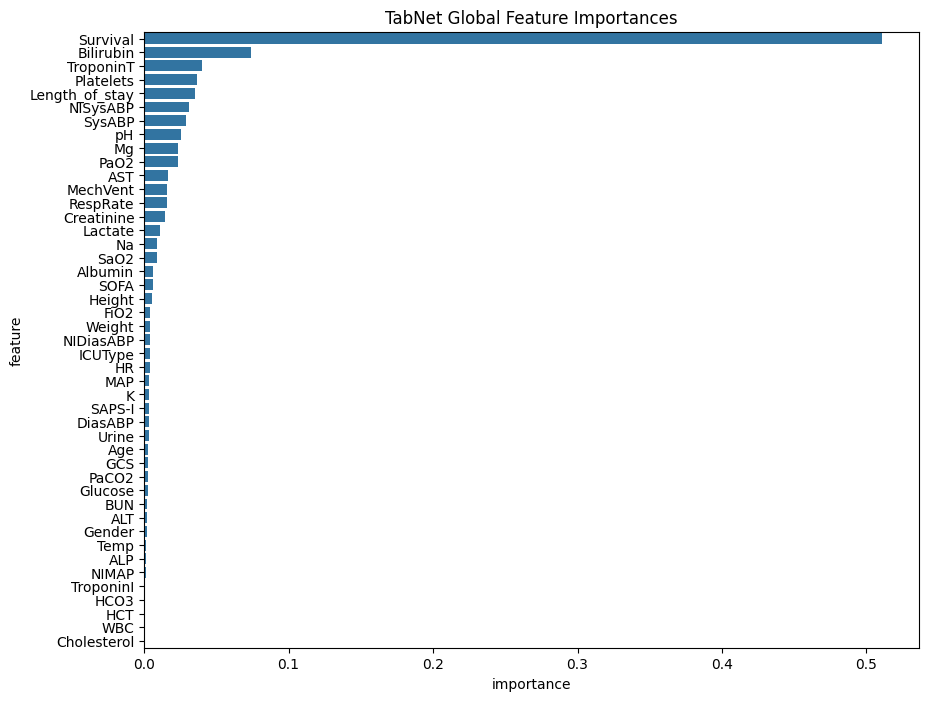

In [27]:
importances = tabnet_clf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('TabNet Global Feature Importances')
plt.show()

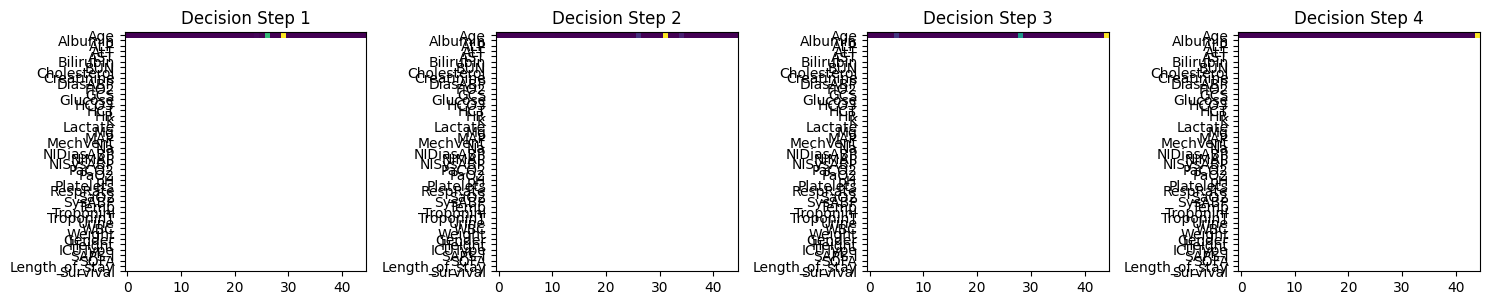

In [28]:
patient_index = 0
patient_sample = X_test_np[patient_index:patient_index+1]

explain_matrix, masks = tabnet_clf.explain(patient_sample)

fig, axs = plt.subplots(1, tabnet_clf.n_steps, figsize=(15, 5))
for i in range(tabnet_clf.n_steps):
    axs[i].imshow(masks[i])
    axs[i].set_title(f"Decision Step {i+1}")
    axs[i].set_yticks(np.arange(len(features)))
    axs[i].set_yticklabels(features)
plt.tight_layout()
plt.show()

In [29]:
y_pred_tabnet = tabnet_clf.predict(X_test_np)
y_pred_proba_tabnet = tabnet_clf.predict_proba(X_test_np)[:, 1]

print("TabNet Classification Report:")
print(classification_report(y_test_np, y_pred_tabnet, target_names=['Survived', 'Died']))

auc_tabnet = roc_auc_score(y_test_np, y_pred_proba_tabnet)
print(f"TabNet AUC-ROC Score: {auc_tabnet:.4f}")

TabNet Classification Report:
              precision    recall  f1-score   support

    Survived       1.00      0.87      0.93       689
        Died       0.55      1.00      0.71       111

    accuracy                           0.89       800
   macro avg       0.77      0.93      0.82       800
weighted avg       0.94      0.89      0.90       800

TabNet AUC-ROC Score: 0.9844


In [30]:

import dice_ml

dice_dataframe = full_df[features + [target]].copy()
continuous_features_list = [f for f in features if dice_dataframe[f].dtype != 'object']

dice_data = dice_ml.Data(
    dataframe=dice_dataframe,
    continuous_features=continuous_features_list,
    outcome_name=target
)

dice_model_xgb = dice_ml.Model(
    model=best_xgb_clf,
    backend='sklearn',
    model_type='classifier'
)

dice_explainer_xgb = dice_ml.Dice(dice_data, dice_model_xgb, method="random")

print("DiCE explainer initialized successfully with XGBoost model.")

DiCE explainer initialized successfully with XGBoost model.


In [47]:
dice_dataframe.head()

,Age,Albumin,ALP,ALT,AST,Bilirubin,BUN,Cholesterol,Creatinine,DiasABP,...,WBC,Weight,Gender,Height,ICUType,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
0,56.0,NaN,66.0,26.0,77.0,1.7,14.000000,NaN,0.70,89.571429,...,15.433333,108.167857,1.0,177.8,4.0,13.0,8.0,15.0,NaN,0
1,90.0,2.75,960.0,146.5,374.0,0.5,24.000000,NaN,1.00,NaN,...,14.166667,NaN,1.0,NaN,4.0,12.0,1.0,10.0,NaN,0
2,77.0,NaN,NaN,NaN,NaN,NaN,48.500000,NaN,1.85,42.852941,...,17.400000,59.000000,1.0,162.6,1.0,8.0,3.0,54.0,55.0,0
3,90.0,NaN,NaN,NaN,NaN,NaN,18.000000,NaN,1.10,47.031746,...,10.700000,65.000000,0.0,NaN,4.0,11.0,2.0,6.0,5.0,1
4,89.0,NaN,178.0,99.0,54.0,0.6,14.333333,NaN,0.95,NaN,...,20.300000,94.092187,0.0,NaN,3.0,15.0,5.0,13.0,NaN,0


In [31]:
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)

In [46]:
import dice_ml

X_test_df = pd.DataFrame(X_test, columns=X.columns)
predicted_death_indices = X_test_df[(xgb_clf.predict(X_test) == 1)].index

if len(predicted_death_indices) > 0:
    patient_idx = predicted_death_indices[0]
    query_instance = X_test_df.loc[[patient_idx]]

    print(f"Selected patient RecordID: {full_df.loc[patient_idx, 'RecordID']}")
    print(f"Original prediction for patient {full_df.loc[patient_idx, 'RecordID']}: {xgb_clf.predict(query_instance)[0]}")

    dice_df = pd.concat([X_test_df, y_test.reset_index(drop=True)], axis=1)

    d = dice_ml.Data(dataframe=dice_df, continuous_features=X_test_df.columns.tolist(), outcome_name='In-hospital_death')

    m = dice_ml.Model(model=xgb_clf, backend='sklearn')

    exp = dice_ml.Dice(d, m, method='random')

    dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=5, desired_class="opposite")

    counterfactuals_df = dice_exp.cf_examples_list[0].final_cfs_df
    print("\nGenerated Counterfactuals:")
    display(counterfactuals_df)
else:
    print("No patients predicted to die in the test set. Cannot generate counterfactuals for flipping prediction from 1 to 0.")

No patients predicted to die in the test set. Cannot generate counterfactuals for flipping prediction from 1 to 0.


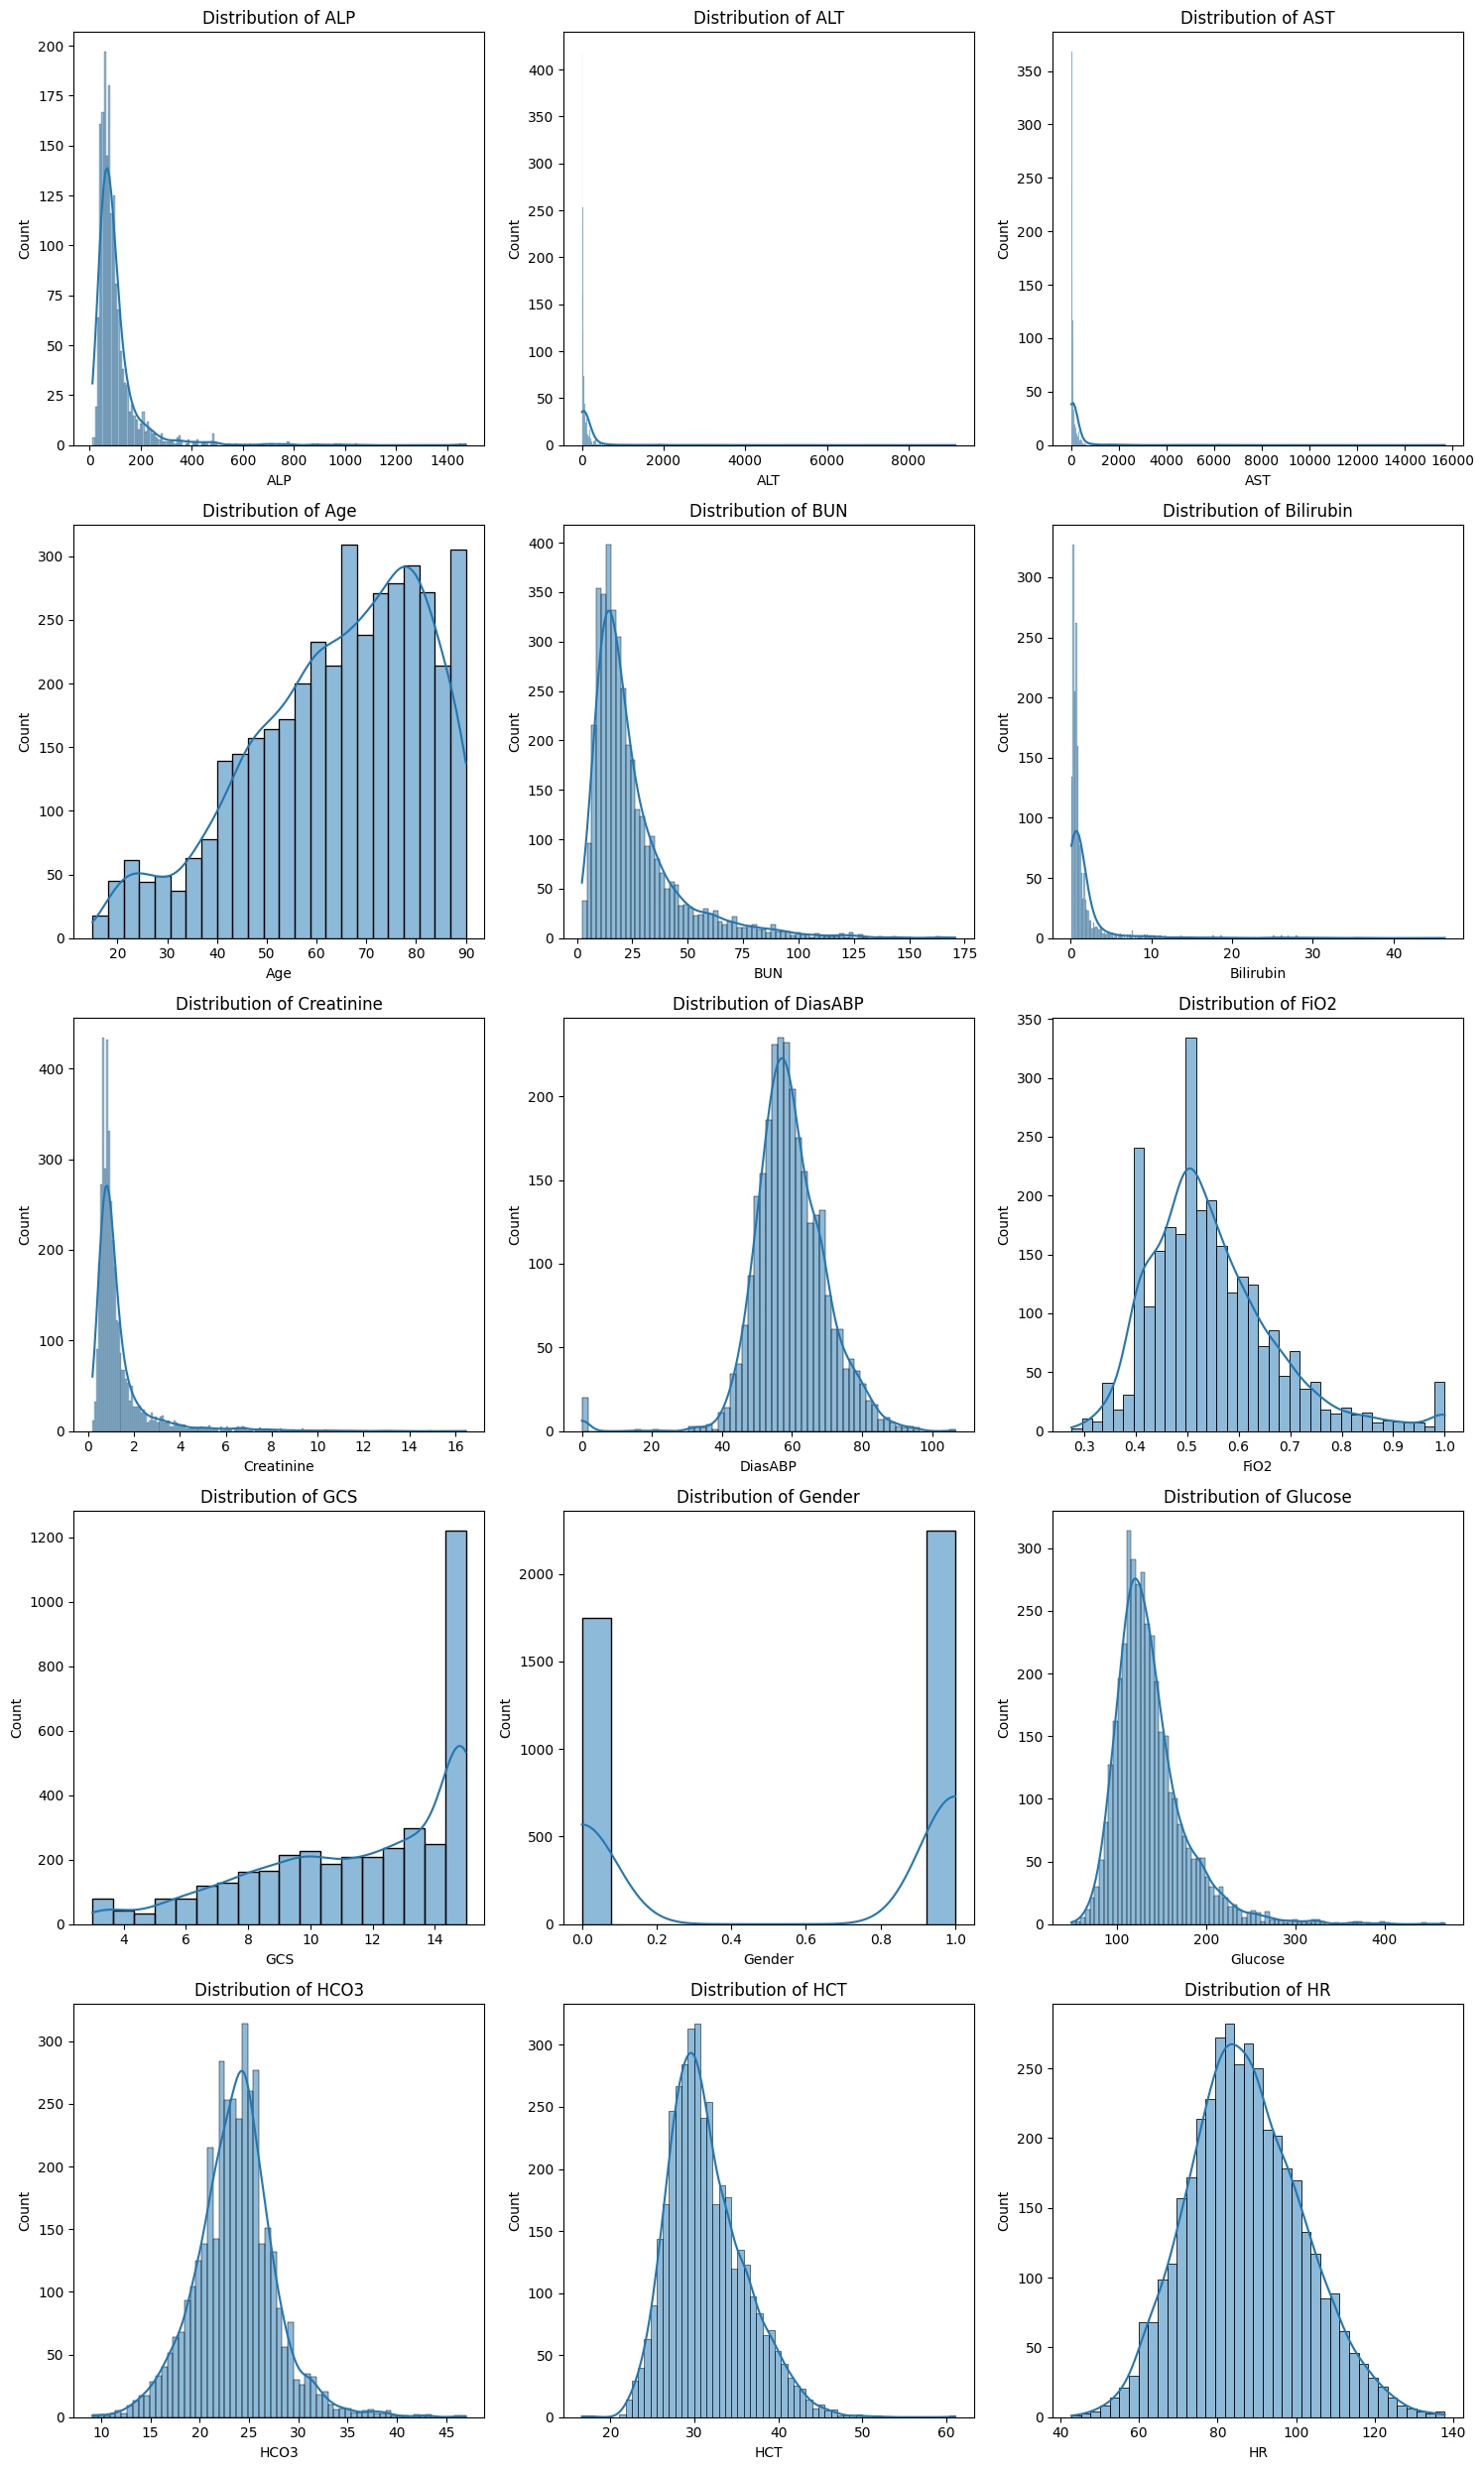

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numerical columns for plotting distributions
numerical_features = full_df.select_dtypes(include=np.number).columns.tolist()

# Exclude RecordID, SAPS-I, SOFA, Length_of_stay, Survival, and In-hospital_death as these are not standard features for distribution plotting
features_to_exclude = ['RecordID', 'SAPS-I', 'SOFA', 'Length_of_stay', 'Survival', 'In-hospital_death']
numerical_features_for_plotting = [f for f in numerical_features if f not in features_to_exclude]

# Plot histograms for numerical features
# We'll plot a subset of features to keep the output manageable
subset_features = numerical_features_for_plotting[:15] # Plotting the first 15 numerical features

n_cols = 3
n_rows = (len(subset_features) + n_cols - 1) // n_cols

plt.figure(figsize=(15, n_rows * 5))
for i, feature in enumerate(subset_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data=full_df, x=feature, kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# You can modify the subset_features list to visualize other numerical features

In [72]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import dice_ml

# Assuming best_xgb_clf, full_df, features, target, X_train_processed, X_test_processed are already defined

# Build a DiCE-compatible dataframe
dice_df_for_dice = full_df[features + ["In-hospital_death"]].copy()
continuous_features_list = [
    f for f in features if dice_df_for_dice[f].dtype != "object"
]

# Impute missing values in the dataframe used for DiCE Data object
# We still need to impute for the DiCE Data object itself
imputer_dice_data = SimpleImputer(strategy="median")
dice_df_for_dice_imputed = pd.DataFrame(imputer_dice_data.fit_transform(dice_df_for_dice), columns=dice_df_for_dice.columns)


d = dice_ml.Data(
    dataframe=dice_df_for_dice_imputed, # Use the imputed dataframe for DiCE Data
    continuous_features=continuous_features_list,
    outcome_name="In-hospital_death",
)

m = dice_ml.Model(model=best_xgb_clf, backend="sklearn", model_type="classifier")

# Use genetic method (more robust than random) - This method was previously attempted but failed
exp = dice_ml.Dice(d, m, method="genetic")

# Predict probabilities
y_pred_proba_xgb_best = best_xgb_clf.predict_proba(X_test_processed)[:, 1]
predicted_death_indices = X_test_processed[(best_xgb_clf.predict(X_test_processed) == 1)].index

if len(predicted_death_indices) > 0:
    # Pick the first patient predicted to die
    patient_idx = predicted_death_indices[0]
    query_instance = X_test_processed.loc[[patient_idx]]

    # Fix: Fit the imputer for the query instance on the preprocessed training data
    imputer_query = SimpleImputer(strategy='median')
    imputer_query.fit(X_train_processed) # Fit on X_train_processed

    # Impute the query instance - although X_test_processed is already imputed,
    # this step is kept for consistency with the original logic if needed for other scenarios.
    # In this specific case, since X_test_processed is already imputed, this line is effectively redundant
    # but won't cause harm.
    query_instance_imputed = pd.DataFrame(
        imputer_query.transform(query_instance), # Use the imputer fitted on X_train_processed
        columns=query_instance.columns,
        index=query_instance.index,
    )

    record_id_for_query = full_df.loc[query_instance_imputed.index[0], "RecordID"]

    print(f"Selected patient RecordID: {record_id_for_query}")
    original_prediction_proba = best_xgb_clf.predict_proba(query_instance)[0][1]
    print(
        f"Original prediction probability for patient {record_id_for_query}: {original_prediction_proba:.4f}"
    )

    # Generate counterfactuals (allow all features to vary initially)
    dice_exp = exp.generate_counterfactuals(
        query_instances=query_instance_imputed,
        total_CFs=5,
        desired_class="opposite",
        features_to_vary="all",
    )

    print("\nGenerated Counterfactuals:")
    dice_exp.visualize_as_dataframe(show_only_changes=True)

else:
    print("No patients predicted to die in the test set. Cannot generate counterfactuals.")

Selected patient RecordID: 138255.0
Original prediction probability for patient 138255.0: 0.9885


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Generated Counterfactuals:
Query instance (original outcome : 1)


,Age,Albumin,ALP,ALT,AST,Bilirubin,BUN,Cholesterol,Creatinine,DiasABP,...,WBC,Weight,Gender,Height,ICUType,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
0,0.266822,0.020822,-0.157079,-0.141526,-0.142498,-0.172515,-0.344349,-0.02848,-0.577925,0.997712,...,-0.289618,-0.997772,-1.139671,-0.318081,0.243319,-0.966678,-0.671128,-0.294609,-0.494197,1



Diverse Counterfactual set (new outcome: 0)


,Age,Albumin,ALP,ALT,AST,Bilirubin,BUN,Cholesterol,Creatinine,DiasABP,...,WBC,Weight,Gender,Height,ICUType,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
0,15.0,1.1,12.0,3.0,6.0,0.1,2.2,28.0,0.2,0.0,...,0.1,3.5,0.0,1.8,1.0,1.0,0.0,1.0,3.0,0.0
0,15.0,1.1,12.0,3.0,6.0,0.1,2.2,28.0,0.2,0.0,...,0.1,3.5,0.0,1.8,1.0,1.0,0.0,6.0,0.0,0.0
0,15.0,1.1,12.0,3.0,6.0,2.5,2.2,153.0,0.2,0.0,...,0.1,3.5,0.0,1.8,1.0,1.0,11.0,1.0,0.0,0.0
0,15.0,1.1,12.0,3.0,6.0,0.1,2.2,28.0,0.2,0.0,...,5.695,3.5,0.0,1.8,1.0,1.0,0.0,1.0,0.0,0.0
0,15.0,1.1,12.0,3.0,6.0,0.1,2.2,28.0,0.2,0.0,...,5.695,3.5,0.0,1.8,1.0,1.0,0.0,1.0,0.0,0.0


Part 2